In [1]:
import os

In [2]:
import random

In [3]:
import torch
import torch.nn as nn
from torchvision import models
import cv2
import numpy as np

In [4]:
import cv2 as cv

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import glob
import matplotlib.pyplot as plt

In [6]:
import matplotlib.patches as patches

In [7]:
%matplotlib inline

In [8]:
def metric_complete(metric,threshold):
    iou, ds = metric
    ds = ds[0:238]
    TP = 0
    FP = 0
    FN = 0
    for x in ds:
        if(x>=threshold):
            TP = TP + 1
        else:
            FP = FP + 1
            FN = FN + 1
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    print("TP: ",TP,"FP: ",FP,"FN: ",FN,"Precision: ",precision," Recall: ", recall," Threshold: ",threshold)

In [9]:
def map_To_Bbox_yolo_nuevo(saliencyMap, porcentage = 0.99):
    maxValue = saliencyMap.max()
    _, thresh = cv2.threshold(saliencyMap, int(porcentage*maxValue), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #plt.imshow(thresh)
    #plt.show()
    #plt.close()
    if len(contours) == 0:
        return []
    else:
        #plt.imshow(thresh)
    # Calcular el bounding box de cada contorno
        bounding_boxes = []
    
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:]
        for contour in contours:
            bounding_box = cv2.boundingRect(contour)
            x,y,w,h      = bounding_box
            #print(bounding_box)
            x = x + (w/2)
            y = y + (h/2)
            #print(x,y,w,h)
            bounding_boxes.append((x,y,w,h))
                     
    return bounding_boxes

In [10]:
def get_label_nuevo(label):
    with open(label, "r") as file:
        # Leer todas las líneas del archivo
        lines = file.readlines()
    lines = lines[0].split(" ")
    #print(lines)
    label = [float(num) for num in lines]
    label = label[1:]
    label = [x * 512 for x in label] 
    return label

In [11]:
###Escogiendo el mayor mostra ahora si plotenando bien
##mostraremos todos lo mapas APC3 PC3 UC3
def get_metric_mostrar_nuevo(folder,testsm1,testsm2,testsm3,testlabels,testoriginal,porcentage = 0.9):
    tamm = len(testsm1)
    iou_tt_1 = []
    dice_score_tt_1 = []
    iou_tt_2 = []
    dice_score_tt_2 = []
    iou_tt_3 = []
    dice_score_tt_3 = []
    
    for i in range(tamm):
        name_test1 = testsm1[i].split('/')[-1].split('.')[0]
        name_test2 = testsm2[i].split('/')[-1].split('.')[0]
        name_test3 = testsm3[i].split('/')[-1].split('.')[0]
        name_label = testlabels[i].split('/')[-1].split('.')[0]
        name_test_png = testoriginal[i].split('/')[-1].split('.')[0]
        
        if(name_test1 == name_label):
            label = get_label_nuevo(testlabels[i])
            
            img1 = cv2.imread(testsm1[i])
            gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
            img2 = cv2.imread(testsm2[i])
            gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
            img3 = cv2.imread(testsm3[i])
            gray3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)
            
            
            labels_generated1 = map_To_Bbox_yolo_nuevo(gray1, porcentage)
            labels_generated2 = map_To_Bbox_yolo_nuevo(gray2, porcentage)
            labels_generated3 = map_To_Bbox_yolo_nuevo(gray3, porcentage)
            
            iou_t1 = []
            dice_score_t1 = []
            
            for label_generated1 in labels_generated1:
                iou = getIOU_nuevo(label_generated1, label)
                dice_score = getDiceScore_nuevo(label_generated1, label)
                iou_t1.append(iou)
                dice_score_t1.append(dice_score)
        
            iou1 = max(iou_t1)
            dice_score1 = max(dice_score_t1)
            
            iou_t2 = []
            dice_score_t2 = []
            
            for label_generated2 in labels_generated2:
                iou = getIOU_nuevo(label_generated2, label)
                dice_score = getDiceScore_nuevo(label_generated2, label)
                iou_t2.append(iou)
                dice_score_t2.append(dice_score)
        
            iou2 = max(iou_t2)
            dice_score2 = max(dice_score_t2)
            
            iou_t3 = []
            dice_score_t3 = []
            
            for label_generated3 in labels_generated3:
                iou = getIOU_nuevo(label_generated3, label)
                dice_score = getDiceScore_nuevo(label_generated3, label)
                iou_t3.append(iou)
                dice_score_t3.append(dice_score)
        
            iou3 = max(iou_t3)
            dice_score3 = max(dice_score_t3)
            
    
            if(name_test1 == name_test_png):
                
                position_dice_score1 = dice_score_t1.index(dice_score1)
                labels_gene_max1 = labels_generated1[position_dice_score1]
                #labels_gene_max1 = [x * 512 for x in labels_gene_max1] 
                
                position_dice_score2 = dice_score_t2.index(dice_score2)
                labels_gene_max2 = labels_generated2[position_dice_score2]
                #labels_gene_max2 = [x * 512 for x in labels_gene_max2] 
                
                position_dice_score3 = dice_score_t3.index(dice_score3)
                labels_gene_max3 = labels_generated3[position_dice_score3]
                #labels_gene_max3 = [x * 512 for x in labels_gene_max3] 
                
                
                #label = [x * 512 for x in label]
                
                x,y,w,h = label 
                x = (x-(w/2))
                y = (y-(h/2))
                
                x1,y1,w1,h1 = labels_gene_max1
                x1 = (x1-(w1/2))
                y1 = (y1-(h1/2))
                
                x2,y2,w2,h2 = labels_gene_max2
                x2 = (x2-(w2/2))
                y2 = (y2-(h2/2))
                
                x3,y3,w3,h3 = labels_gene_max3
                x3 = (x3-(w3/2))
                y3 = (y3-(h3/2))
                
                
                img_ori = cv2.imread(testoriginal[i])
                fig, ax = plt.subplots(2, 4, figsize=(14, 7));
                fig.suptitle('name: '+name_test_png+' porcentage: '+str(porcentage))
                ax[0,0].imshow(img_ori, cmap='bone')
                ax[0,0].title.set_text(name_test_png)
                ax[0,0].axis('off')
                ax[1,0].imshow(img_ori, cmap='bone')
                ax[1,0].title.set_text(name_test_png)
                rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
                ax[1,0].add_patch(rect);
                ax[1,0].axis('off')
                
                ax[0,1].imshow(gray1,cmap='jet')
                ax[0,1].title.set_text("APC3")
                ax[0,1].axis('off')
                ax[1,1].imshow(img_ori, cmap='bone')
                ax[1,1].title.set_text('iou: '+str(round(iou1,5))+' DS: '+str(round(dice_score1,5)))
                rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
                ax[1,1].add_patch(rect);
                rect1 = patches.Rectangle((x1,y1),w1,h1, linewidth=3, edgecolor='r', facecolor='none')
                ax[1,1].add_patch(rect1);
                ax[1,1].axis('off')
                
                
                ax[0,2].imshow(gray2,cmap='jet')
                ax[0,2].title.set_text("PC3")
                ax[0,2].axis('off')
                ax[1,2].imshow(img_ori, cmap='bone')
                ax[1,2].title.set_text('iou: '+str(round(iou2,5))+' DS: '+str(round(dice_score2,5)))
                rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
                ax[1,2].add_patch(rect);
                rect2 = patches.Rectangle((x2,y2),w2,h2, linewidth=2, edgecolor='r', facecolor='none')
                ax[1,2].add_patch(rect2);
                ax[1,2].axis('off')
                
                ax[0,3].imshow(gray3,cmap='jet')
                ax[0,3].title.set_text("UC3")
                ax[0,3].axis('off')
                ax[1,3].imshow(img_ori, cmap='bone')
                ax[1,3].title.set_text('iou: '+str(round(iou3,5))+' DS: '+str(round(dice_score3,5)))
                rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
                ax[1,3].add_patch(rect);
                rect3 = patches.Rectangle((x3,y3),w3,h3, linewidth=2, edgecolor='r', facecolor='none')
                ax[1,3].add_patch(rect3);
                ax[1,3].axis('off')
                #plt.show()
                plt.savefig(f'results/{folder}/{name_test_png}', dpi=100, bbox_inches='tight',pad_inches=0);  #dpi=113.2
                #plt.close();
        #break

In [12]:
def get_metric_g_nuevo(testsm,testlabels,porcentage = 0.9):  # g de gray
    tamm = len(testsm)
    iou_tt = []
    dice_score_tt = []
    for i in range(tamm):
        name_test = testsm[i].split('/')[-1].split('.')[0]
        name_label = testlabels[i].split('/')[-1].split('.')[0]
        if(name_test == name_label):
            label = get_label_nuevo(testlabels[i])
            #print(label)
            img = cv2.imread(testsm[i])
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            labels_generated = map_To_Bbox_yolo_nuevo(gray, porcentage)
            #print(labels_generated)
            iou_t = []
            dice_score_t = []
            #print(labels_generated)
            for label_generated in labels_generated:
                iou = getIOU_nuevo(label_generated, label)
                dice_score = getDiceScore_nuevo(label_generated, label)
                iou_t.append(iou)
                dice_score_t.append(dice_score)
            iou1 = max(iou_t)
            #position_iou1 = iou_t.index(iou1)
            #labels_gene_max = labels_generated[position_iou1]
            #labels_gene_max = [x * 512 for x in labels_gene_max] 
            dice_score1 = max(dice_score_t)
            #print(name_test, name_label, iou1, dice_score1)
            iou_tt.append(iou1)
            dice_score_tt.append(dice_score1)
    dice_score_test = sum(dice_score_tt)/len(dice_score_tt)
    iou_test = sum(iou_tt)/len(iou_tt)
    iou_tt.append(iou_test)
    dice_score_tt.append(dice_score_test)
    print("IOU: "+str(iou_test)+" Dice_Score: "+str(dice_score_test)+" porcentage: "+str(porcentage))
    return iou_tt, dice_score_tt

In [13]:
def get_metric_g_nuevo_mostrar(testsm,testlabels,porcentage = 0.9):  # g de gray
    tamm = len(testsm)
    iou_tt = []
    dice_score_tt = []
    for i in range(tamm):
        name_test = testsm[i].split('/')[-1].split('.')[0]
        name_label = testlabels[i].split('/')[-1].split('.')[0]
        if(name_test == name_label):
            label = get_label_nuevo(testlabels[i])
            #print(label)
            img = cv2.imread(testsm[i])
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            labels_generated = map_To_Bbox_yolo_nuevo(gray, porcentage)
            #print(labels_generated)
            iou_t = []
            dice_score_t = []
            #print(labels_generated)
            for label_generated in labels_generated:
                iou = getIOU_nuevo(label_generated, label)
                dice_score = getDiceScore_nuevo(label_generated, label)
                iou_t.append(iou)
                dice_score_t.append(dice_score)
            iou1 = max(iou_t)
            #position_iou1 = iou_t.index(iou1)
            #labels_gene_max = labels_generated[position_iou1]
            #labels_gene_max = [x * 512 for x in labels_gene_max] 
            dice_score1 = max(dice_score_t)
            print(name_test, name_label, iou1, dice_score1)
            iou_tt.append(iou1)
            dice_score_tt.append(dice_score1)
    dice_score_test = sum(dice_score_tt)/len(dice_score_tt)
    iou_test = sum(iou_tt)/len(iou_tt)
    iou_tt.append(iou_test)
    dice_score_tt.append(dice_score_test)
    print("IOU: "+str(iou_test)+" Dice_Score: "+str(dice_score_test)+" porcentage: "+str(porcentage))
    return iou_tt, dice_score_tt

In [31]:
def getDiceScore_nuevo(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x11 = round(x1 - ((w1)/2))
    x111 = round(x1 + ((w1)/2))
    y11 = round(y1 - ((h1)/2))
    y111 = round(y1 + ((h1)/2))
    x22 = round(x2 - ((w2)/2))
    x222 = round(x2 + ((w2)/2))
    y22 = round(y2 - ((h2)/2))
    y222 = round(y2 + ((h2)/2))
    #print(x11,y11,x111,y111)
    #print(x22,y22,x222,y222)
    bin_mask1 = np.zeros((512, 512))
    bin_mask1[x11:x111, y11:y111] = 1
    bin_mask2 = np.zeros((512, 512))
    bin_mask2[x22:x222, y22:y222]= 1
    intersection = np.sum(np.logical_and(bin_mask1, bin_mask2))
    union = np.sum(np.logical_or(bin_mask1, bin_mask2))
    dice_score = (2.0 * intersection) / (union + intersection)
    #print("Dice score: ", dice_coef)
    return dice_score
    

In [14]:
def get_metric_nuevo(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x11 = round(x1 - ((w1)/2))
    x111 = round(x1 + ((w1)/2))
    y11 = round(y1 - ((h1)/2))
    y111 = round(y1 + ((h1)/2))
    x22 = round(x2 - ((w2)/2))
    x222 = round(x2 + ((w2)/2))
    y22 = round(y2 - ((h2)/2))
    y222 = round(y2 + ((h2)/2))
    #print(x11,y11,x111,y111)
    #print(x22,y22,x222,y222)
    bin_mask1 = np.zeros((512, 512))
    bin_mask1[x11:x111, y11:y111] = 1
    bin_mask2 = np.zeros((512, 512))
    bin_mask2[x22:x222, y22:y222]= 1
    #intersection = np.sum(np.logical_and(bin_mask1, bin_mask2))
    TP = np.sum(np.logical_and(bin_mask1, bin_mask2))
    #union = np.sum(np.logical_or(bin_mask1, bin_mask2))
    FN = np.sum(np.logical_and(bin_mask2,1))-TP #ground true
    FP = np.sum(np.logical_and(bin_mask1,1))-TP
    
    #dice_coef = (2.0 * intersection) / (union + intersection)
    dice = 2(TP)/(2(TP)+FP+FN)
    presicion = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    #print("Dice score: ", dice)
    return dice_coef, presicion, recall

In [15]:
def get_metric_g_nuevo(testsm,testlabels,porcentage = 0.9):  # g de gray
    tamm = len(testsm)
    iou_tt = []
    dice_score_tt = []
    for i in range(tamm):
        name_test = testsm[i].split('/')[-1].split('.')[0]
        name_label = testlabels[i].split('/')[-1].split('.')[0]
        if(name_test == name_label):
            label = get_label_nuevo(testlabels[i])
            #print(label)
            img = cv2.imread(testsm[i])
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            labels_generated = map_To_Bbox_yolo_nuevo(gray, porcentage)
            #print(labels_generated)
            iou_t = []
            dice_score_t = []
            #print(labels_generated)
            for label_generated in labels_generated:
                iou = getIOU_nuevo(label_generated, label)
                dice_score = getDiceScore_nuevo(label_generated, label)
                iou_t.append(iou)
                dice_score_t.append(dice_score)
            iou1 = max(iou_t)
            #position_iou1 = iou_t.index(iou1)
            #labels_gene_max = labels_generated[position_iou1]
            #labels_gene_max = [x * 512 for x in labels_gene_max] 
            dice_score1 = max(dice_score_t)
            #print(name_test, name_label, iou1, dice_score1)
            iou_tt.append(iou1)
            dice_score_tt.append(dice_score1)
    dice_score_test = sum(dice_score_tt)/len(dice_score_tt)
    iou_test = sum(iou_tt)/len(iou_tt)
    iou_tt.append(iou_test)
    dice_score_tt.append(dice_score_test)
    print("IOU: "+str(iou_test)+" Dice_Score: "+str(dice_score_test)+" Thershold: "+str(porcentage))
    return iou_tt, dice_score_tt

In [16]:
def getIOU_nuevo(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x11 = round(x1 - ((w1)/2))
    x111 = round(x1 + ((w1)/2))
    y11 = round(y1 - ((h1)/2))
    y111 = round(y1 + ((h1)/2))
    x22 = round(x2 - ((w2)/2))
    x222 = round(x2 + ((w2)/2))
    y22 = round(y2 - ((h2)/2))
    y222 = round(y2 + ((h2)/2))
    #print(x11,y11,x111,y111)
    #print(x22,y22,x222,y222)
    bin_mask1 = np.zeros((512, 512))
    bin_mask1[x11:x111, y11:y111] = 1
    bin_mask2 = np.zeros((512, 512))
    bin_mask2[x22:x222, y22:y222]= 1
    intersection = np.sum(np.logical_and(bin_mask1, bin_mask2))
    union = np.sum(np.logical_or(bin_mask1, bin_mask2))
    iou = (intersection) / union
    #print("Dice score: ", dice_coef)
    return iou

In [38]:
def regresion(x,y,evaluar):
    print(x[0],x[1],y[0],y[1])
    m = (y[1]-y[0])/(x[1]-x[0])
    print(m)
    y1 = m*(evaluar-x[0])+y[0]
    print("x: ",evaluar,"y: ",y1)
    return evaluar,y1

In [24]:
def metric_complete(saliencys,grounds_truth,porcentage,threshold,iteration):
    tam_t = len(saliencys)
    TP = 0 
    FN = 0
    FP = 0 
    for i in range(tam_t):
        TP1,FN1,FP1 = metric_slice(saliencys[i],grounds_truth[i],porcentage,threshold,iteration)
        TP = TP + FP1
        FN = FN + FN1
        FP = FP + FP1
    ##abajo calcular recall:
    recall = TP / (TP+FN)
    FP_mean = FP/tam_t
    print("recall: "+str(recall)+" FP_mean: "+str(FP_mean)+" iteration: "+str(iteration))
    return recall,FP_mean,iteration

In [25]:
def metric_slice(testsm,testlabel,porcentage,threshold,iteration):
    name_test = testsm.split('/')[-1].split('.')[0]
    name_label = testlabel.split('/')[-1].split('.')[0]
    
    if(name_test == name_label):
        #print(name_test,name_label)
        label = get_label_nuevo(testlabel)
        img = cv2.imread(testsm)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        #plt.imshow(gray, cmap='jet')
        #plt.show()
        #plt.close()
        
    dice_score_c = []
    labels_generated_c = []
    
    for i in range(iteration):
        labels_generated = map_To_Bbox_yolo_nuevo(gray,porcentage)
        label_generated, dice_score = best_dice_score(label,labels_generated)
        dice_score_c.append(dice_score)
        labels_generated_c.append(label_generated)
        gray1 = new_saliency_map(gray,label_generated)
        #plt.imshow(gray1)
        #plt.show()
        #plt.close()
        
    #print(dice_score_c)
    #print(labels_generated_c)
    i_max = dice_score_c.index(max(dice_score_c))
    #print(dice_score_c[i_max], labels_generated_c[i_max])
    
    if(dice_score_c[i_max]>=threshold):
        TP = 1
        FN = 0
        FP = sum(1 for i in dice_score_c if i<threshold)
    else:
        TP = 0
        FN = 1
        FP = sum(1 for i in dice_score_c if i<threshold)
    #print(TP,FN,FP)
    
    return TP,FN,FP

In [17]:
bin_mask1 = np.zeros((512, 512))
bin_mask1[0:100, 0:100] = 1
bin_mask2 = np.zeros((512, 512))
bin_mask2[50:100, 50:100]= 1
intersection = np.sum(np.logical_and(bin_mask1, bin_mask2))
TP = intersection
union = np.sum(np.logical_or(bin_mask1, bin_mask2))
FP = np.sum(np.logical_and(bin_mask2,1))-TP
FN = np.sum(np.logical_and(bin_mask1,1))-TP
print("TP: ",TP," FP: ",FP," FN: ",FN, "Union: ",union," intersection: ",intersection)

TP:  2500  FP:  0  FN:  7500 Union:  10000  intersection:  2500


In [59]:
test0265 = '/home/dylanvr/Mi proyecto de grado/Proyecto_Guaya/datasetS/test/images/0265_P0159-74.png'

In [61]:
label0265 = '/home/dylanvr/Mi proyecto de grado/Proyecto_Guaya/datasetS/labels/test/0265_P0159-74.txt'

In [64]:
import matplotlib.pyplot as plt

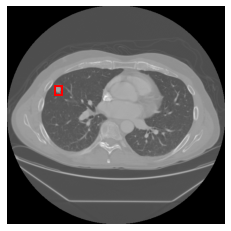

In [71]:
name_test1 = test0265.split('/')[-1].split('.')[0]
name_label = test0265.split('/')[-1].split('.')[0]
img_ori = cv2.imread(test0265)
label = get_label_nuevo(label0265)
x,y,w,h = label
x = (x-(w/2))
y = (y-(h/2))
fig, ax = plt.subplots();
ax.imshow(img_ori, cmap='bone')
ax.axis('off')
rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.savefig('0265.png',dpi=169.8,bbox_inches='tight',pad_inches=0)

### Carpeta

In [18]:
testoriginal = sorted(glob.glob('/home/dylanvr/Mi proyecto de grado/Proyecto_Guaya/datasetS/test/images/*png'))

In [19]:
testlabels = sorted(glob.glob('/home/dylanvr/Mi proyecto de grado/Proyecto_Guaya/datasetS/labels/test/*txt'))

In [20]:
testsm_P_MUC3 = sorted(glob.glob('/home/dylanvr/Mi proyecto de grado/yolo/yolov5/results/best_propoused/MUC3/*png'))

In [22]:
testsm_P_MPC3 = sorted(glob.glob('/home/dylanvr/Mi proyecto de grado/yolo/yolov5/results/best_propoused/MPC3/*png'))

In [45]:
testsm_P_MAPC3 = sorted(glob.glob('/home/dylanvr/Mi proyecto de grado/yolo/yolov5/results/best_propoused/MAPC3/*png'))

### Metric Yolo_2

In [469]:
porcentage = 0.9
testsm3 = testsm_D_MUC3
tamm = len(testsm3)
iou_tt_3 = []
dice_score_tt_3 = []
name_test3 = testsm3[0].split('/')[-1].split('.')[0]
name_label = testlabels[0].split('/')[-1].split('.')[0]
name_test_png = testoriginal[0].split('/')[-1].split('.')[0]

0003_P0001-90 0003_P0001-90


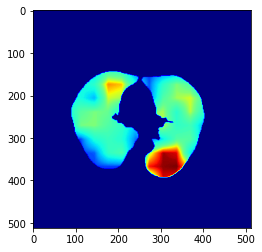

In [470]:
if(name_test3 == name_label):
    print(name_test3,name_label)
    label = get_label_nuevo(testlabels[0])
    img3 = cv2.imread(testsm3[0])
    gray3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)
    plt.imshow(gray3, cmap='jet')

In [471]:
labels_generated3 = map_To_Bbox_yolo_nuevo(gray3, porcentage)

In [472]:
best_ds = best_dice_score(label,labels_generated3)

In [473]:
best_ds[0]

(311.5, 362.5, 75, 59)

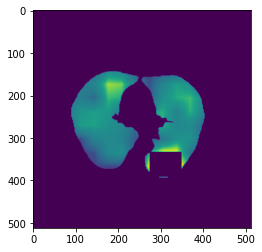

In [474]:
dice_score_c = []
labels_generated_c = []
for i in range(1):
    labels_generated = map_To_Bbox_yolo_nuevo(gray3, 0.9)
    label_generated, dice_score = best_dice_score(label,labels_generated)
    dice_score_c.append(dice_score)
    labels_generated_c.append(label_generated)
    gray33 = new_saliency_map(gray3,label_generated)
    plt.imshow(gray3)
    plt.show()
    plt.close()

In [475]:
dice_score_c

[0.6816624460002979]

In [476]:
labels_generated_c

[(311.5, 362.5, 75, 59)]

In [447]:
i_max = dice_score_c.index(max(dice_score_c))

In [448]:
print(dice_score_c[i_max])

0.6438722386379626


In [449]:
print(labels_generated_c[i_max])

(311.5, 361.5, 79, 61)


In [450]:
threshold = 0.05

In [479]:
if(dice_score_c[i_max]>=threshold):
    TP1 = 1
    FN1 = 0
    FP1 = sum(1 for i in dice_score_c if i<threshold)
else:
    TP1 = 0
    FN1 = 1
    FP1 = sum(1 for i in dice_score_c if i<threshold)

In [480]:
print(TP1,FN1,FP1)

1 0 0


### UC3

In [32]:
porcentage = 0.96
threshold = 0.05
iteration = 1
metric_complete(testsm_P_MUC3,testlabels,porcentage,threshold,iteration)

recall: 0.5 FP_mean: 0.9873949579831933 iteration: 1


(0.5, 0.9873949579831933, 1)

In [33]:
### voy hacerlo para n interaciones:
for x in range(1,14):
    print(x)
    metric_complete(testsm_P_MUC3,testlabels,porcentage,threshold,x)
    #break

1
recall: 0.5 FP_mean: 0.9873949579831933 iteration: 1
2
recall: 0.6690442225392297 FP_mean: 1.9705882352941178 iteration: 2
3
recall: 0.7542918454935622 FP_mean: 2.953781512605042 iteration: 3
4
recall: 0.8051502145922746 FP_mean: 3.9411764705882355 iteration: 4
5
recall: 0.8386866523911491 FP_mean: 4.936974789915967 iteration: 5
6
recall: 0.8628291488058788 FP_mean: 5.920168067226891 iteration: 6
7
recall: 0.880277926242651 FP_mean: 6.920168067226891 iteration: 7
8
recall: 0.8940114068441065 FP_mean: 7.9033613445378155 iteration: 8
9
recall: 0.9047008547008547 FP_mean: 8.894957983193278 iteration: 9
10
recall: 0.9138198757763976 FP_mean: 9.890756302521009 iteration: 10
11
recall: 0.9210526315789473 FP_mean: 10.882352941176471 iteration: 11
12
recall: 0.9271653543307087 FP_mean: 11.873949579831933 iteration: 12
13
recall: 0.9324200913242009 FP_mean: 12.869747899159664 iteration: 13


In [39]:
x8 = [7.9033613445378155,8.894957983193278]
y8 = [0.8940114068441065,0.9047008547008547]
evaluar = 8
for8 = regresion(x8,y8,evaluar)

7.9033613445378155 8.894957983193278 0.8940114068441065 0.9047008547008547
0.010780036397907073
x:  8 y:  0.8950531750674336


In [40]:
x4 = [3.9411764705882355,4.936974789915967]
y4 = [0.8051502145922746,0.8386866523911491]
evaluar = 4
for4 = regresion(x4,y4,evaluar)

3.9411764705882355 4.936974789915967 0.8051502145922746 0.8386866523911491
0.033677941755831775
x:  4 y:  0.8071312699896765


In [41]:
x2 = [1.9705882352941178,2.953781512605042]
y2 = [0.6690442225392297,0.7542918454935622]
evaluar = 2
for2 = regresion(x2,y2,evaluar)

1.9705882352941178 2.953781512605042 0.6690442225392297 0.7542918454935622
0.0867048472783382
x:  2 y:  0.6715943651062396


In [42]:
x1 = [0.9873949579831933, 1.9705882352941178]
y1 = [0.5, 0.6690442225392297]
evaluar = 1
for1 = regresion(x1,y1,evaluar)

0.9873949579831933 1.9705882352941178 0.5 0.6690442225392297
0.1719338673689601
x:  1 y:  0.5021672336222978


In [43]:
SUMACPM = 0.5021672336222978 + 0.6715943651062396 + 0.8071312699896765 + 0.8950531750674336
CPM = SUMACPM/4
print(CPM)

0.7189865109464119


### Para la capa otra capa testsm_D_MPC3

In [34]:
### voy hacerlo para n interaciones:
for x in range(1,12):
    print(x)
    metric_complete(testsm_P_MPC3,testlabels,porcentage,threshold,x)
    #break

1
recall: 0.5 FP_mean: 0.9117647058823529 iteration: 1
2
recall: 0.6781045751633987 FP_mean: 1.7436974789915967 iteration: 2
3
recall: 0.7675276752767528 FP_mean: 2.6218487394957983 iteration: 3
4
recall: 0.8182701652089407 FP_mean: 3.53781512605042 iteration: 4
5
recall: 0.8523274478330658 FP_mean: 4.46218487394958 iteration: 5
6
recall: 0.8773006134969326 FP_mean: 5.407563025210084 iteration: 6
7
recall: 0.8937685459940653 FP_mean: 6.3277310924369745 iteration: 7
8
recall: 0.9073196419167984 FP_mean: 7.239495798319328 iteration: 8
9
recall: 0.918241965973535 FP_mean: 8.163865546218487 iteration: 9
10
recall: 0.927592116538132 FP_mean: 9.096638655462185 iteration: 10
11
recall: 0.934375 FP_mean: 10.050420168067227 iteration: 11


In [47]:
x8 = [7.239495798319328, 8.163865546218487]
y8 = [0.9073196419167984, 0.918241965973535 ]
evaluar = 8
for05 = regresion(x8,y8,evaluar)

7.239495798319328 8.163865546218487 0.9073196419167984 0.918241965973535
0.011815968752287843
x:  8 y:  0.9163057357998408


In [48]:
x4 = [3.53781512605042, 4.46218487394958]
y4 = [0.8182701652089407, 0.8523274478330658]
evaluar = 4
for05 = regresion(x4,y4,evaluar)

3.53781512605042 4.46218487394958 0.8182701652089407 0.8523274478330658
0.03684378756609897
x:  4 y:  0.8352988065210032


In [49]:
x2 = [1.7436974789915967, 2.6218487394957983]
y2 = [0.6781045751633987, 0.7675276752767528]
evaluar = 2
for02 = regresion(x2,y2,evaluar)

1.7436974789915967 2.6218487394957983 0.6781045751633987 0.7675276752767528
0.10183109008123575
x:  2 y:  0.7042041402682533


In [57]:
x1 = [0.9117647058823529,1.7436974789915967]
y1 = [0.5,0.6781045751633987]
evaluar = 1
for01 = regresion(x1,y1,evaluar)

0.9117647058823529 1.7436974789915967 0.5 0.6781045751633987
0.21408529741863078
x:  1 y:  0.5188898791839969


In [58]:
SUMACAPM = 0.5188898791839969 + 0.7042041402682533 + 0.8352988065210032 + 0.9163057357998408
CPMAP = SUMACAPM/4
print(CPMAP)

0.7436746404432735


### Para la capa otra capa testsm_D_MAPC3

In [46]:
### voy hacerlo para n interaciones:
for x in range(1,12):
    print(x)
    metric_complete(testsm_P_MAPC3,testlabels,porcentage,threshold,x)
    #break

1
recall: 0.5 FP_mean: 0.957983193277311 iteration: 1
2
recall: 0.6897689768976898 FP_mean: 1.7563025210084033 iteration: 2
3
recall: 0.7780487804878049 FP_mean: 2.680672268907563 iteration: 3
4
recall: 0.8277511961722488 FP_mean: 3.634453781512605 iteration: 4
5
recall: 0.85973207249803 FP_mean: 4.584033613445378 iteration: 5
6
recall: 0.8821954484605087 FP_mean: 5.53781512605042 iteration: 6
7
recall: 0.8990075890251021 FP_mean: 6.470588235294118 iteration: 7
8
recall: 0.9110539845758355 FP_mean: 7.445378151260504 iteration: 8
9
recall: 0.9205693296602387 FP_mean: 8.42436974789916 iteration: 9
10
recall: 0.9286010792860108 FP_mean: 9.399159663865547 iteration: 10
11
recall: 0.9349470499243571 FP_mean: 10.38655462184874 iteration: 11


In [52]:
x8 = [7.445378151260504, 8.42436974789916]
y8 = [0.9110539845758355, 0.9205693296602387]
evaluar = 8
for05 = regresion(x8,y8,evaluar)

7.445378151260504 8.42436974789916 0.9110539845758355 0.9205693296602387
0.009719537039004142
x:  8 y:  0.9164446521773


In [53]:
x4 = [3.634453781512605, 4.584033613445378]
y4 = [0.8277511961722488, 0.85973207249803]
evaluar = 4
for04 = regresion(x4,y4,evaluar)

3.634453781512605 4.584033613445378 0.8277511961722488 0.85973207249803
0.033678975953698766
x:  4 y:  0.8400624184746512


In [54]:
x2 = [1.7563025210084033,2.680672268907563]
y2 = [0.6897689768976898,0.7780487804878049]
evaluar = 2
for02 = regresion(x2,y2,evaluar)

1.7563025210084033 2.680672268907563 0.6897689768976898 0.7780487804878049
0.09550269661112455
x:  2 y:  0.7130427432987202


In [55]:
x1 = [0.957983193277311,1.7563025210084033]
y1 = [0.5,0.6897689768976898]
evaluar = 1
for02 = regresion(x1,y1,evaluar)

0.957983193277311 1.7563025210084033 0.5 0.6897689768976898
0.23771061316657985
x:  1 y:  0.5099878408893521


In [56]:
SUMACAPM = 0.5099878408893521 + 0.7130427432987202 + 0.8400624184746512 + 0.9164446521773
CPMAP = SUMACAPM/4
print(CPMAP)

0.7448844137100059


### Cambiando el thrshold

#### para un threshold = 0.4

In [609]:
porcentage = 0.96
threshold = 0.4
iteration = 1
metric_complete(testsm_D_MAPC3,testlabels,porcentage,threshold,iteration)

recall: 0.5 FP_mean: 0.9495798319327731 iteration: 1


(0.5, 0.9495798319327731, 1)

In [610]:
### voy hacerlo para n interaciones:
for x in range(1,12):
    print(x)
    metric_complete(testsm_D_MAPC3,testlabels,porcentage,threshold,x)
    #break

1
recall: 0.5 FP_mean: 0.9495798319327731 iteration: 1
2
recall: 0.6705882352941176 FP_mean: 1.915966386554622 iteration: 2
3
recall: 0.7551912568306011 FP_mean: 2.903361344537815 iteration: 3
4
recall: 0.8053866203301477 FP_mean: 3.8949579831932772 iteration: 4
5
recall: 0.8386167146974063 FP_mean: 4.890756302521009 iteration: 5
6
recall: 0.8622386223862238 FP_mean: 5.890756302521009 iteration: 6
7
recall: 0.8798283261802575 FP_mean: 6.890756302521009 iteration: 7
8
recall: 0.8933333333333333 FP_mean: 7.882352941176471 iteration: 8
9
recall: 0.904150620453573 FP_mean: 8.878151260504202 iteration: 9
10
recall: 0.913009708737864 FP_mean: 9.878151260504202 iteration: 10
11
recall: 0.9203697120511909 FP_mean: 10.878151260504202 iteration: 11


In [612]:
x8 = [7.882352941176471,8.878151260504202]
y8 = [0.8933333333333333,0.904150620453573]
evaluar = 8
for4 = regresion(x8,y8,evaluar)

0.9159663865546218 8.878151260504202 0.8933333333333333 0.904150620453573
0.010862929681928436
x:  8 y:  0.894611325060619


In [616]:
x4 = [3.8949579831932772,4.890756302521009]
y4 = [0.8053866203301477,0.8386167146974063]
evaluar = 4
for4 = regresion(x4,y4,evaluar)

0.9159663865546218 4.890756302521009 0.8053866203301477 0.8386167146974063
0.03337030573589675
x:  4 y:  0.8088919045461033


In [566]:
porcentage = 0.96
threshold = 0.05
iteration = 1
metric_complete(testsm_D_MAPC3,testlabels,porcentage,threshold,iteration)

recall: 0.5 FP_mean: 0.9159663865546218 iteration: 1


(0.5, 0.9159663865546218, 1)

In [599]:
### voy hacerlo para n interaciones:
for x in range(1,12):
    print(x)
    metric_complete(testsm_D_MAPC3,testlabels,porcentage,threshold,x)
    #break

1
recall: 0.5 FP_mean: 0.9159663865546218 iteration: 1
2
recall: 0.6712121212121213 FP_mean: 1.861344537815126 iteration: 2
3
recall: 0.7562076749435666 FP_mean: 2.8151260504201683 iteration: 3
4
recall: 0.8071748878923767 FP_mean: 3.7815126050420167 iteration: 4
5
recall: 0.8403860430586488 FP_mean: 4.756302521008403 iteration: 5
6
recall: 0.8640960809102401 FP_mean: 5.743697478991597 iteration: 6
7
recall: 0.8820936639118457 FP_mean: 6.726890756302521 iteration: 7
8
recall: 0.8955588091752075 FP_mean: 7.7100840336134455 iteration: 8
9
recall: 0.9063457330415755 FP_mean: 8.701680672268907 iteration: 9
10
recall: 0.9151130503768345 FP_mean: 9.693277310924369 iteration: 10
11
recall: 0.9223793978962641 FP_mean: 10.684873949579831 iteration: 11


In [603]:
x8 = [7.7100840336134455,8.701680672268907]
y8 = [0.8955588091752075,0.9063457330415755]
evaluar = 8
for1 = regresion(x8,y8,evaluar)

0.6428571428571429 8.701680672268907 0.8955588091752075 0.9063457330415755
0.010878338475405064
x:  8 y:  0.8987126131869846


In [604]:
x4 = [3.7815126050420167,4.756302521008403]
y4 = [0.8071748878923767 ,0.8403860430586488]
evaluar = 4
for1 = regresion(x4,y4,evaluar)

0.6428571428571429 4.756302521008403 0.8071748878923767 0.8403860430586488
0.034070064351606776
x:  4 y:  0.8146187674986101


In [605]:
x2 = [1.861344537815126,2.8151260504201683]
y2 = [0.6712121212121213,0.7562076749435666]
evaluar = 2
for1 = regresion(x2,y2,evaluar)

0.6428571428571429 2.8151260504201683 0.6712121212121213 0.7562076749435666
0.08911428100477523
x:  2 y:  0.6835683030321111


In [606]:
x1 = [0.9159663865546218, 1.861344537815126]
y1 = [0.5, 0.6712121212121213]
evaluar = 1
for1 = regresion(x1,y1,evaluar)

0.9159663865546218 1.861344537815126 0.5 0.6712121212121213
0.18110437710437713
x:  1 y:  0.5152188552188552


In [607]:
x = [0.9159663865546218, 1.861344537815126]
y = [0.5, 0.6712121212121213]
evaluar = 0.5
for05 = regresion(x,y,evaluar)

0.9159663865546218 1.861344537815126 0.5 0.6712121212121213
0.18110437710437713
x:  0.5 y:  0.42466666666666664


In [608]:
SUMACPMAP = 0.42466666666666664 + 0.5152188552188552 + 0.6835683030321111 + 0.8146187674986101 + 0.8987126131869846
CPMAP = SUMACPMAP/5
print(CPMAP)

0.6673570411206455


0004_P0003-75 0004_P0003-75


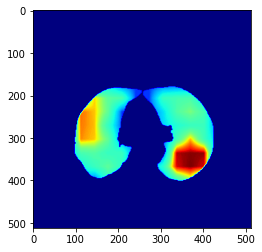

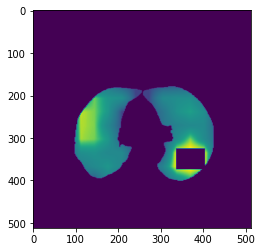

[0.7014809041309431]
[(370.0, 349.5, 68, 49)]
0.7014809041309431 (370.0, 349.5, 68, 49)
1 0 0


In [488]:
name_test1 = testsm3[1].split('/')[-1].split('.')[0]
name_label = testlabels[1].split('/')[-1].split('.')[0]
name_test_png = testoriginal[1].split('/')[-1].split('.')[0]
if(name_test1 == name_label):
    print(name_test1,name_label)
    label = get_label_nuevo(testlabels[1])
    img1 = cv2.imread(testsm3[1])
    gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    plt.imshow(gray1, cmap='jet')
    plt.show()
    plt.close()
    
dice_score_c = []
labels_generated_c = []
for i in range(1):
    labels_generated = map_To_Bbox_yolo_nuevo(gray1, 0.9)
    label_generated, dice_score = best_dice_score(label,labels_generated)
    dice_score_c.append(dice_score)
    labels_generated_c.append(label_generated)
    gray1 = new_saliency_map(gray1,label_generated)
    plt.imshow(gray1)
    plt.show()
    plt.close()
print(dice_score_c)
print(labels_generated_c)
i_max = dice_score_c.index(max(dice_score_c))
print(dice_score_c[i_max], labels_generated_c[i_max])
threshold = 0.05
if(dice_score_c[i_max]>=threshold):
    TP2 = 1
    FN2 = 0
    FP2 = sum(1 for i in dice_score_c if i<threshold)
else:
    TP2 = 0
    FN2 = 1
    FP2 = sum(1 for i in dice_score_c if i<threshold)
print(TP2,FN2,FP2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [499]:
porcentage = 0.9
threshold = 0.05
metric_slice(testsm3[1],testlabels[1],porcentage,threshold,1)

0004_P0003-75 0004_P0003-75
1 0 0


(1, 0, 0)

In [ ]:
TP = TP1 + TP2

In [460]:
print(type(dice_score_c))

<class 'list'>


In [466]:
mi_vector = [2, 7, 3, 8, 6, 9, 1, 4, 5, 10]
conteo = sum(1 for i in mi_vector if i > 5)
print("El número de elementos que cumplen la condición es:", conteo)


El número de elementos que cumplen la condición es: 5


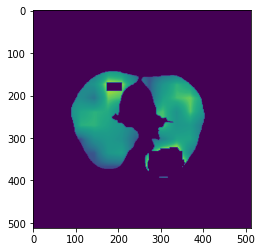

In [453]:
plt.imshow(gray3)

In [399]:
gray = new_saliency_map(gray3,best_ds[0])

In [311]:
maxValue = gray3.max()
_, thresh = cv2.threshold(gray3, int(porcentage*maxValue), 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

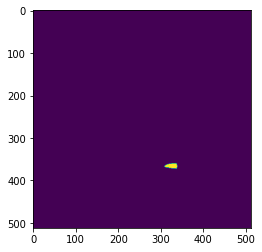

In [312]:
plt.imshow(thresh)

In [328]:
labels_generated3 = map_To_Bbox_yolo_nuevo(gray3, porcentage)

In [314]:
print(labels_generated3) ##

[(323.5, 366.5, 31, 13)]


In [315]:
dice_score_t = []

In [318]:
for label_generated in labels_generated3:
    dice_score = getDiceScore_nuevo(label_generated, label)
    dice_score_t.append(dice_score)

In [319]:
#ordenar de mayor a menor el vector
print(dice_score_t)


[0.2995169082125604]


In [320]:
x,y,w,h = label 
x = round(x-(w/2))
y = round(y-(h/2))

x3,y3,w3,h3 = labels_generated3[0]
x3 = round(x3-(w3/2))
y3 = round(y3-(h3/2))

(-0.5, 511.5, 511.5, -0.5)

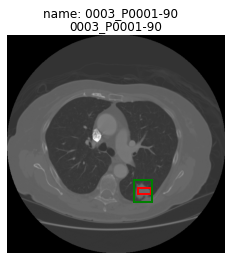

In [321]:
img_ori = cv2.imread(testoriginal[0])
fig, ax = plt.subplots()
fig.suptitle('name: '+name_test_png)
ax.imshow(img_ori, cmap='bone')
ax.title.set_text(name_test_png)
ax.axis('off')
ax.imshow(img_ori, cmap='bone')
ax.title.set_text(name_test_png)
rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
rect_1 = patches.Rectangle((x3,y3),w3,h3, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect_1);
ax.add_patch(rect);
ax.axis('off')

In [322]:
gray33 = gray3.copy()

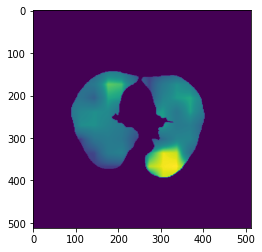

In [323]:
plt.imshow(gray33)

In [324]:
minsm = gray33.min()
#print(minsm)
x33 = round(x3+w3)
y33 = round(y3+h3)
print(x3,y3,w3,h3)
gray33[y3:y33,x3:x33] = minsm

308 360 31 13


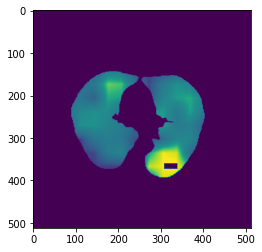

In [325]:
plt.imshow(gray33)

In [332]:
minValue = gray33.min()
maxValue = gray33.max()
_, thresh = cv2.threshold(gray33, int(porcentage*maxValue), 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

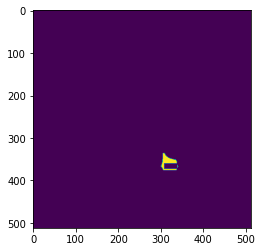

In [331]:
plt.imshow(thresh)

In [333]:
labels_generated33 = map_To_Bbox_yolo_nuevo(gray33, porcentage)

In [334]:
print(labels_generated33)

[(319.0, 356.0, 38, 40), (340.0, 367.0, 2, 6)]


In [339]:
print(sorted(labels_generated33))

[(319.0, 356.0, 38, 40), (340.0, 367.0, 2, 6)]


In [335]:
dice_score_t = []

In [336]:
for label_generated in labels_generated33:
    dice_score = getDiceScore_nuevo(label_generated, label)
    dice_score_t.append(dice_score)

In [338]:
print(dice_score_t)

[0.7184873949579832, 0.010434782608695653]


In [ ]:
### para cuando haya mas contornos deberiamos coger el mayor

In [340]:
x,y,w,h = label 
x = round(x-(w/2))
y = round(y-(h/2))

x3,y3,w3,h3 = labels_generated33[0]
x3 = round(x3-(w3/2))
y3 = round(y3-(h3/2))


(-0.5, 511.5, 511.5, -0.5)

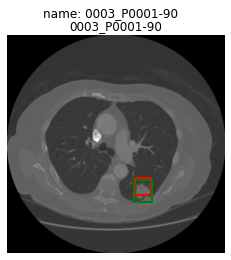

In [341]:
img_ori = cv2.imread(testoriginal[0])
fig, ax = plt.subplots()
fig.suptitle('name: '+name_test_png)
ax.imshow(img_ori, cmap='bone')
ax.title.set_text(name_test_png)
ax.axis('off')
ax.imshow(img_ori, cmap='bone')
ax.title.set_text(name_test_png)
rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
rect_1 = patches.Rectangle((x3,y3),w3,h3, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect_1);
ax.add_patch(rect);
ax.axis('off')

(-0.5, 511.5, 511.5, -0.5)

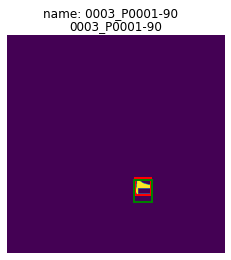

In [346]:
#voy a visualizar el tresh y el bbox a ver que sucede 
img_ori = cv2.imread(testoriginal[0])
fig, ax = plt.subplots()
fig.suptitle('name: '+name_test_png)
#ax.imshow(img_ori, cmap='bone')
#ax.title.set_text(name_test_png)
#ax.axis('off')
ax.imshow(thresh)
ax.title.set_text(name_test_png)
rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
rect_1 = patches.Rectangle((x3,y3),w3,h3, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect_1);
ax.add_patch(rect);
ax.axis('off')

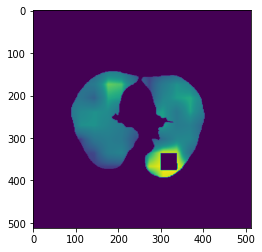

In [435]:
plt.imshow(gray33)

In [436]:
gray333 = gray33.copy()

In [438]:
gray333 = gray33.copy()
x33 = round(x3+w3)
y33 = round(y3+h3)
print(x3,y3,w3,h3)
gray33[y3:y33,x3:x33] = minsm

339 364 2 6


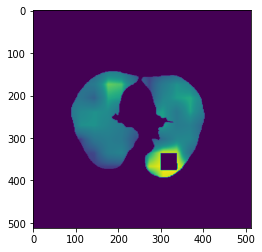

In [439]:
plt.imshow(gray333)

In [352]:
minValue = gray333.min()
maxValue = gray333.max()
_, thresh = cv2.threshold(gray333, int(porcentage*maxValue), 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

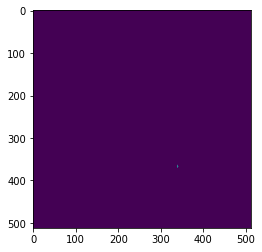

In [353]:
plt.imshow(thresh)

In [359]:
labels_generated333 = map_To_Bbox_yolo_nuevo(gray333, porcentage)

In [360]:
print(labels_generated33)

[(340.0, 367.0, 2, 6)]


In [361]:
x,y,w,h = label 
x = round(x-(w/2))
y = round(y-(h/2))

x3,y3,w3,h3 = labels_generated333[0]
x3 = round(x3-(w3/2))
y3 = round(y3-(h3/2))

(-0.5, 511.5, 511.5, -0.5)

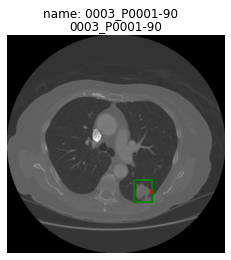

In [362]:
img_ori = cv2.imread(testoriginal[0])
fig, ax = plt.subplots()
fig.suptitle('name: '+name_test_png)
ax.imshow(img_ori, cmap='bone')
ax.title.set_text(name_test_png)
rect = patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='g', facecolor='none')
rect_1 = patches.Rectangle((x3,y3),w3,h3, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect_1);
ax.add_patch(rect);
ax.axis('off')

In [26]:
### creacion de la funcion:
def best_dice_score(label_true,labels_generated):
    dice_score_t = []
    for label_generated in labels_generated:
        dice_score = getDiceScore_nuevo(label_true,label_generated)
        dice_score_t.append(dice_score)
    position_ds = dice_score_t.index(max(dice_score_t))
    dice_score = dice_score_t[position_ds]
    label_generated = labels_generated[position_ds]
    return label_generated,dice_score

In [27]:
def new_saliency_map(gray,label_generated):
    #gray = cv.cvtColor(maps, cv.COLOR_BGR2GRAY)
    min_value = gray.min()
    x,y,w,h = label_generated
    x = round(x-(w/2))
    y = round(y-(h/2))
    x1 = round(x+w)
    y1 = round(y+h)
    gray[y:y1,x:x1] = min_value
    return gray

In [28]:
def map_To_Bbox_yolo_nuevo_1(saliencyMap, porcentage = 0.99):
    maxValue = saliencyMap.max()
    _, thresh = cv2.threshold(saliencyMap, int(porcentage*maxValue), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #plt.imshow(thresh)
    #plt.show()
    #plt.close()
    if len(contours) == 0:
        return []
    else:
        #plt.imshow(thresh)
    # Calcular el bounding box de cada contorno
        bounding_boxes = []
    
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:]
        bounding_box = cv2.boundingRect(contour[0])
        """
        for contour in contours:
            bounding_box = cv2.boundingRect(contour)
            x,y,w,h      = bounding_box
            #print(bounding_box)
            x = x + (w/2)
            y = y + (h/2)
            #print(x,y,w,h)
            bounding_boxes.append((x,y,w,h))
         """            
    return bounding_boxes